## 1. test

The objective funciton:   
$$\underset{\theta}{\max}\sum_{i}\log p_{\theta}(x^{(i)})=\underset{\theta}{\max}\sum_{i}\log p_{Z}(f_{\theta}(x^{(i)}))+\log\left|\cfrac{\partial f_{\theta}}{\partial x}(x^{(i)})\right| $$

implementation:
``` python
# objective 
def nll(self, x):
    return - self.log_prob(x).mean()

def log_prob(self, x):
    z, log_det = self.flow(x)
    return self.base_dist.log_prob(z) + log_det
```


In [21]:
ud.log_prob(ptu.FloatTensor([0, 0.1, 0.5, 0.9]))

tensor([0., 0., 0., 0.])

In [30]:
torch.Floa([0])

tensor([0], dtype=torch.int32)

<Figure size 432x288 with 0 Axes>

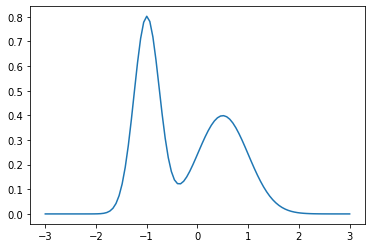

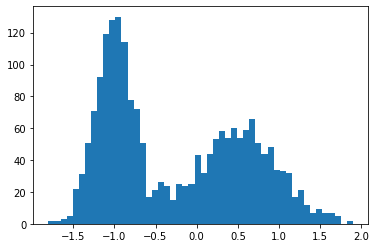

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

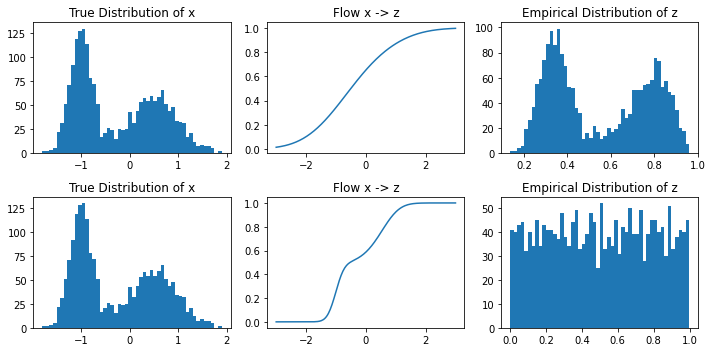

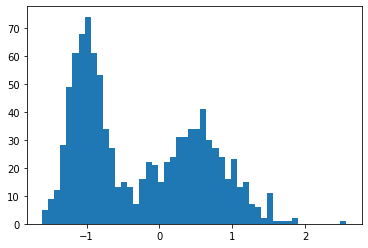

In [31]:
from train import *

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test = 2000, 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_flow_demo_1(n_train, n_test, 
            loader_args, visualize=True, train_only=False)


cdf_flow_model = MixtureCDFFlow(base_dist='uniform', mixture_dist='gaussian',
                    n_components=5).to(ptu.device)
cdf_flow_model_old = copy.deepcopy(cdf_flow_model)
train_epochs(cdf_flow_model, train_loader, test_loader, 
                      dict(epochs=50, lr=5e-3, plot=False))
visualize_demo1_flow(train_loader, cdf_flow_model_old, cdf_flow_model)

ud = Uniform(torch.FloatTensor([0.0]), ptu.FloatTensor([1.0]))
z = ud.rsample(torch.IntTensor([1000]))
x = cdf_flow_model.invert(z);
plt.figure();
plt.hist(ptu.get_numpy(x), bins=50);

## 2. project

It is clear that the gradident is only depend on the Cross-Entropy part.

Therefore, the objective function is:

$$\begin{align}
\underset{\theta}{\min}D_{\mathbb{KL}}(p||q;\theta)&=\underset{\theta}{\min}-\mathbb{\mathbb{E}}_{x\sim q(X;\theta)}\cfrac{p(X)}{q(X;\theta)}\log q(X;\theta) \\
&=\underset{\theta}{\min}-\mathbb{\mathbb{E}}_{x\sim q(X;\theta)}\cfrac{f(X)/c}{q(X;\theta)}\log q(X;\theta) \\
&=\underset{\theta}{\min}-\mathbb{\mathbb{E}}_{x\sim q(X;\theta)}\cfrac{f(X)}{q(X;\theta)}\log q(X;\theta)
	\end{align}$$

where $c$ is the normalizing constant, $f(X)$ is the target function, $q(X;\theta)$ can be estimated using flow model, and the samples are generated from the flow model.

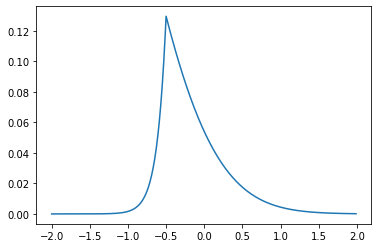

In [108]:
m1 = Normal(torch.tensor([-2]), torch.tensor([1]))
eventLevel = torch.FloatTensor([-0.5])
rho = lambda x : torch.where(x < eventLevel,  
                10*(eventLevel - x), torch.FloatTensor([0]))
def f(x):
    return (m1.log_prob(x) - rho(x)).exp()


x = torch.arange(-2, 2, 0.01)
y = f(x)
plt.plot(x, y) 

Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

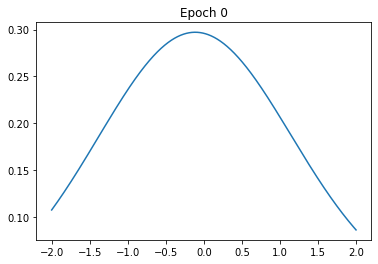

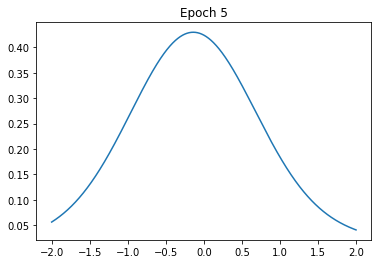

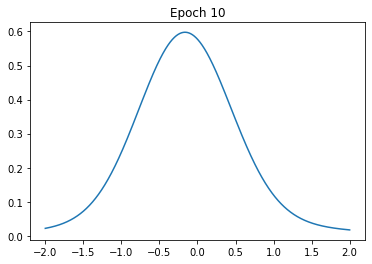

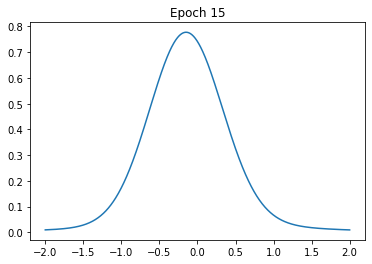

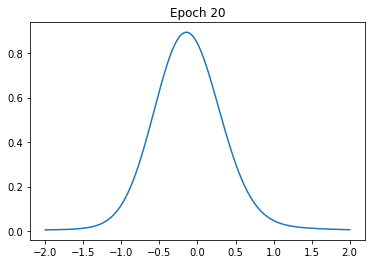

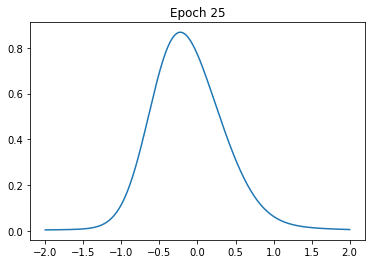

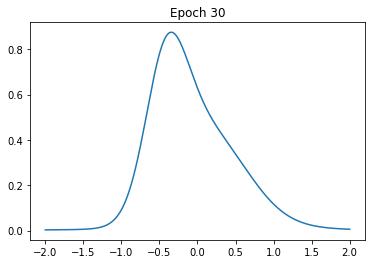

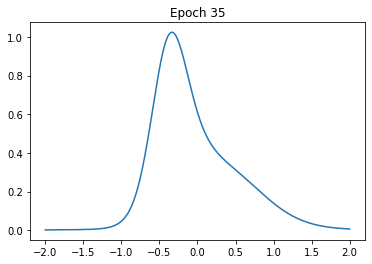

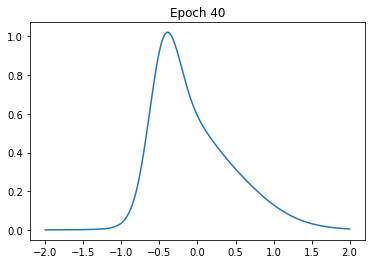

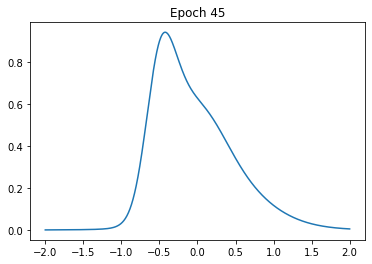

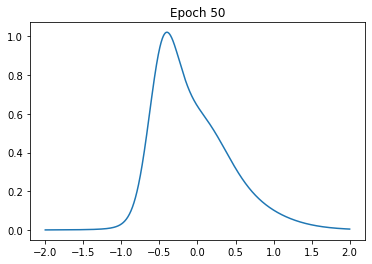

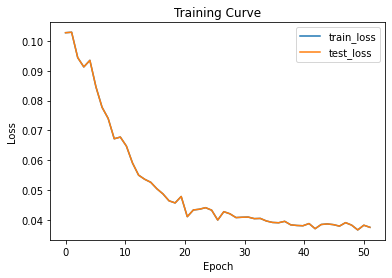

In [110]:
import tqdm
from scipy.stats import norm


# applies gradient steps for each mini-batch in an epoch
def train(model, optimizer):
    model.eval()
    with torch.no_grad():
        x = model.sample(1000)
        
    model.train()
    x = x.to(ptu.device).float()
    
    fx = f(x)
    loss = model.kl(x, fx)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()


def train_epochs(model, train_args):
    # training parameters
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # plotting parameters
    plot = train_args.get('plot', True)
    plot_frequency = train_args.get('plot_frequency', 5)
    if 'epochs_to_plot' in train_args.keys():
        plot_frequency = epochs + 1
        epochs_to_plot = train_args['epochs_to_plot']
    else:
        epochs_to_plot = []

    train_losses, test_losses = [], []
    for epoch in tqdm.notebook.tqdm(range(epochs), desc='Epoch', leave=False):
        model.train()
        train_loss = train(model, optimizer)
        # train_loss = eval_loss(model)
        train_losses.append(train_loss)

        # if test_loader is not None:
        #     test_loss = eval_loss(model, test_loader)
        #     test_losses.append(test_loss)

        if plot and (epoch % plot_frequency == 0 or epoch in epochs_to_plot):
            model.plot(f'Epoch {epoch}')
            
    if plot:
        plot_train_curves(epochs, train_losses, train_losses, title='Training Curve')
    return train_losses, train_losses


SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)

cdf_flow_model = MixtureCDFFlow(base_dist='uniform', mixture_dist='gaussian',
                    n_components=100, plot_bounds=(-2, 2)).to(ptu.device)
cdf_flow_model_old = copy.deepcopy(cdf_flow_model)
train_epochs(cdf_flow_model,  
                      dict(epochs=51, lr=5e-2));
